In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
import matplotlib.cm as cm

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [106]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_TRMM_ERA-I.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))

In [107]:
OBS2.keys()

dict_keys(['year', 'div925', 'pmean', 'lat', 'tmin', 'rh925', 'w925', 't650', 'pmax', 'w650', 't', 't925', 'clon', 'u650', 'area', 'v650', 'lon', 'pgt30', 'shear', 'clat', 'q925', 'pgt01isvalid', 'tmean', 'v925', 'pv925', 'u925', 'q650', 'p', 'rh650', 'month', 'pv650', 'div650', 'hour'])

(array([8.7588e+04, 3.8645e+04, 2.0713e+04, 1.2476e+04, 8.5300e+03,
        6.0640e+03, 4.6990e+03, 3.6490e+03, 2.8980e+03, 2.3130e+03,
        1.8870e+03, 1.4870e+03, 1.2700e+03, 1.0380e+03, 9.3100e+02,
        7.0600e+02, 6.5300e+02, 5.3000e+02, 4.7900e+02, 3.9000e+02,
        3.0400e+02, 2.6800e+02, 2.4300e+02, 1.9900e+02, 1.7900e+02,
        1.4200e+02, 1.3300e+02, 9.7000e+01, 9.9000e+01, 8.7000e+01,
        6.3000e+01, 6.2000e+01, 5.1000e+01, 4.0000e+01, 3.0000e+01,
        2.7000e+01, 1.9000e+01, 2.8000e+01, 1.6000e+01, 1.6000e+01,
        1.6000e+01, 1.6000e+01, 1.4000e+01, 1.0000e+01, 1.0000e+01,
        6.0000e+00, 7.0000e+00, 8.0000e+00, 1.0000e+00, 8.0000e+00]),
 array([  1.  ,   2.98,   4.96,   6.94,   8.92,  10.9 ,  12.88,  14.86,
         16.84,  18.82,  20.8 ,  22.78,  24.76,  26.74,  28.72,  30.7 ,
         32.68,  34.66,  36.64,  38.62,  40.6 ,  42.58,  44.56,  46.54,
         48.52,  50.5 ,  52.48,  54.46,  56.44,  58.42,  60.4 ,  62.38,
         64.36,  66.34,  68.32

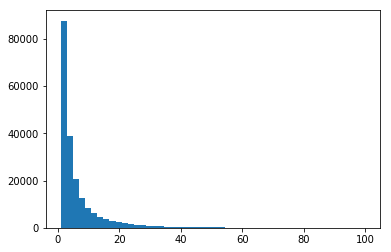

In [56]:
pp = []
for p in OBS['p']:
    pp.extend(np.array(p).flatten())
parr = np.array(pp)
plt.hist(parr, range=(1,100), bins=50)

In [57]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [58]:
obs_trmm = create_dic(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic(OBS3)

In [59]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-12)&(obs_trmm.lon<=10)&(obs_trmm.lat>=5)&(obs_trmm.lon<=8.5)]
obs_gpm = obs_gpm[(obs_gpm.lon>=-12)&(obs_gpm.lon<=10)&(obs_gpm.lat>=5)&(obs_gpm.lon<=8.5)]
obs_40 = obs_40[(obs_40.lon>=-12)&(obs_40.lon<=10)&(obs_40.lat>=5)&(obs_40.lon<=8.5)]

In [60]:
np.min(OBS2['area'])

3

In [61]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 5.001021624302387 9.062473109264518 -11.99840650697918 8.491157113230344
OBS_trmm 5.0105781472051625 10.011255452668484 -11.98423614566575 8.448728425356524
OBS_gpm 5.0010278250489275 8.783227092246435 -11.841122845610268 8.498758747812342


In [62]:
obs_trmm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

Text(0.5, 1.0, '-0.54')

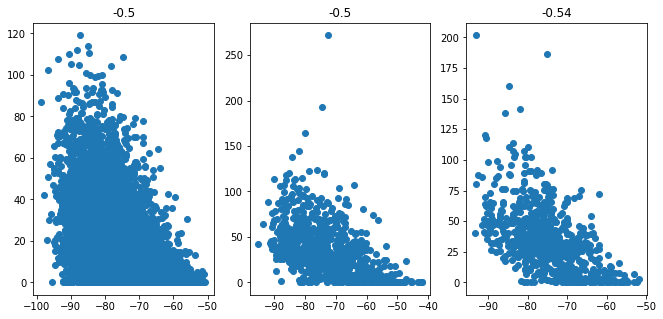

In [63]:
obss = [obs_trmm.tmin, obs_trmm.prcp]
cp4s = [obs_gpm.tmin, obs_gpm.prcp]
cp25s = [obs_40.tmin, obs_40.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [64]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))

In [65]:
ts=pd.Series(np.array(era_out['dates']))

In [66]:
ts.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12])

In [67]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
ttg = np.array(era_out['tmin'])
ttm = np.array(era_out['tmean'])
lat = np.array(era_out['lat'])
lon = np.array(era_out['lon'])
area = np.array(era_out['area'])

In [68]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : ts.dt.month.values,
    'area' : area*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [69]:
ds = ds[(ds.lon>=-12)&(ds.lon<=10)&(ds.lat>=5)&(ds.lat<=8.5)]

In [70]:
ds = ds.dropna()

In [71]:
print(ds.lat.max(),ds.lat.min(),ds.lon.max(),ds.lon.min())
print(ds.area.min())
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

7.980003356933594 5.004997253417969 9.979995727539062 -12.0
4921.070000000001
75
75
1452.0000000000002


In [119]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[(obs_trmm.month == m) & (obs_trmm.prcp>1)],99))
    pgpm.append(np.percentile(obs_gpm.prcp[(obs_gpm.month == m) & (obs_gpm.prcp>1)],99))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[(obs_40.month == m) & (obs_40.prcp>1),99]))
    except:
        ptrmm40.append(np.nan)

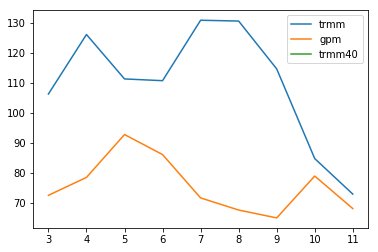

In [120]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

In [82]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.sum((obs_trmm.month == m) & (obs_trmm.prcp>60))/np.sum((obs_trmm.month == m) & (obs_trmm.prcp>1)))
    pgpm.append(np.sum((obs_gpm.month == m) & (obs_gpm.prcp>60))/np.sum((obs_gpm.month == m) & (obs_gpm.prcp>1)))
    try:
        ptrmm40.append(np.sum((obs_40.month == m) & (obs_40.prcp>60))/np.sum((obs_40.month == m) & (obs_40.prcp>1)))
    except:
        ptrmm40.append(np.nan)

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


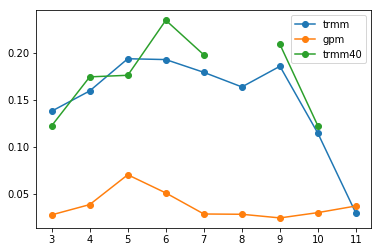

In [85]:
plt.figure()
plt.plot(range(3,12), ptrmm, 'o-',label='trmm')
plt.plot(range(3,12), pgpm, 'o-',label='gpm')
plt.plot(range(3,12), ptrmm40, 'o-',label='trmm40')
plt.legend()

In [115]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.tmin[obs_trmm.month == m],95))
    pgpm.append(np.percentile(obs_gpm.tmin[obs_gpm.month == m],95))
    gridsat.append(np.percentile(ds.tmin[ds.month == m],95))
    try:
        ptrmm40.append(np.percentile(obs_40.tmin[obs_40.month == m],95))
    except:
        ptrmm40.append(np.nan)

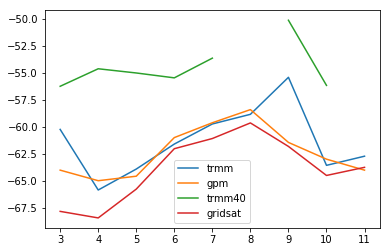

In [116]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.plot(range(3,12), gridsat, label='gridsat')
plt.legend()

3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
5 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
6 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
7 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
8 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
9 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
10 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
11 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/

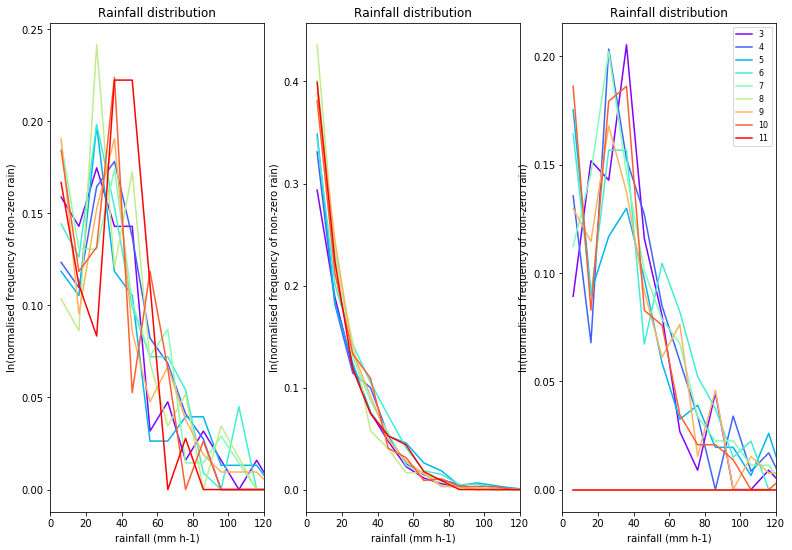

In [96]:
f = plt.figure(figsize=(13,9))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip(np.arange(3,12),colors):
        #print(m)
        
        monthly = (data['prcp'])[data['month'] == m]

        print(m, np)

        #ipdb.set_trace()
        weights = np.ones_like(monthly) / float(len(monthly))
        hist, h = np.histogram(monthly, bins=np.arange(1,201+1,10),  range=(1,201), weights=weights)
        #print(np.arange(20,120+1,10))
        bins=np.arange(1,201+1,10)
        #line, = ax.semilogy(hist, color=c, lw=2, label=str(m))
        mid = bins[1::]-5
        ax.plot(mid,hist, color=c, label=str(m))
    plt.ylabel('ln(normalised frequency of non-zero rain)')
    plt.xlim((0,120))
    plt.xlabel('rainfall (mm h-1)')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


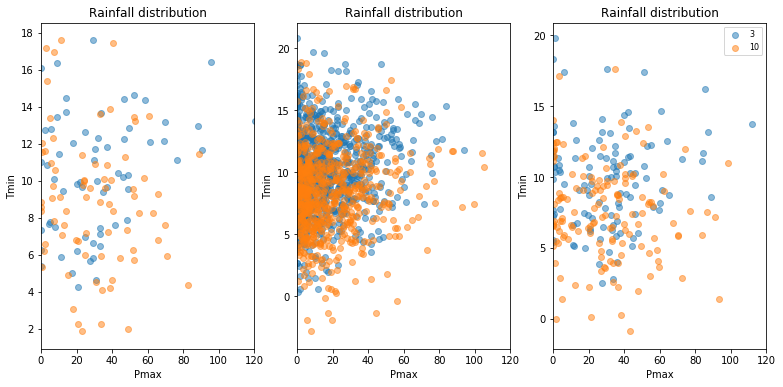

In [113]:
f = plt.figure(figsize=(13,6))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip([3,10],colors):
        #print(m)
#         if m == 5:
        monthly = (data)[data['month'] == m]
#         if m == 9:
        monthly = (data)[data['month'] == m]

        ax.scatter(monthly['prcp'], monthly['shear'], label=str(m), alpha=0.5)
    plt.ylabel('Tmin')
    plt.xlim((0,120))
    plt.xlabel('Pmax')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


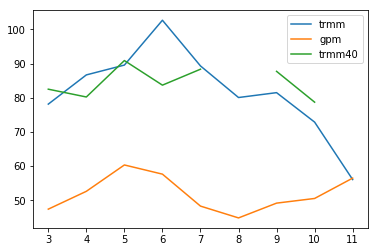

In [31]:
pos1 = ((ds.month>=9) | (ds.month<=5))  & (ds.u650<0) & (ds.area>=5000) # all storms, without trmm overpass - matchup via storm centre points
opos1 =((obs.month>=9) | (obs.month<=5)) & (obs.u650<0) & (obs.area>=5000) # storms with trmm overpass - matchup via cutout kernels

In [32]:
np.sum(cpos1)

19211

In [33]:
oposi = (obs.u650<0) & (obs.area>=5000) & (obs.prcp>=1) & ((obs.month>=9) | (obs.month<=5))

In [34]:
ds_march = ds[pos1]
obs_march = obs[opos1]

In [35]:
obsp = obs[oposi]

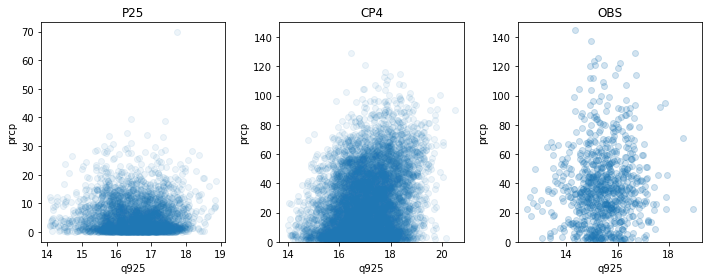

In [27]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

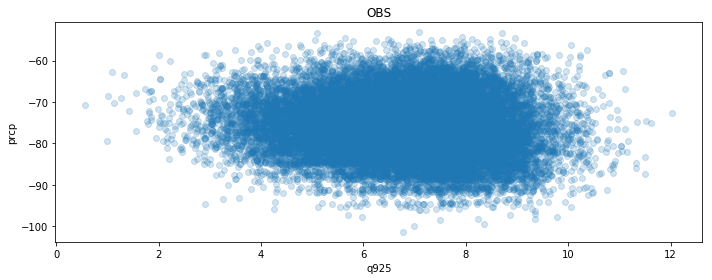

In [39]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
plt.scatter(ds_march.q700, ds_march.tmin, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
#ax.set_ylim(0,150)
plt.tight_layout()

In [35]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [67]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.u650, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.u650, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(223)

    data3, r3 = density_plot(dat.q925, dat.shear, dat.u650)

    mappable = ax2.scatter(dat.q925, dat.shear, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. qq/shear | umax removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data4, r4 = density_plot(dat.q700, dat.tmin, dat.u925)

    mappable = ax2.scatter(dat.q700, dat.tmin , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(0, 10)
    ax2.set_ylabel('min T')
    ax2.set_xlabel('qmid')
    ax2.set_title('P-corr. qq700/tmin | u650hPa removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [68]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

pears (0.255769170282489, 0.0)
pears (-0.18504189204529659, 4.803283502841906e-211)
pears (0.24272989324618527, 0.0)
pears (-0.08632142798275355, 8.595223896077429e-47)


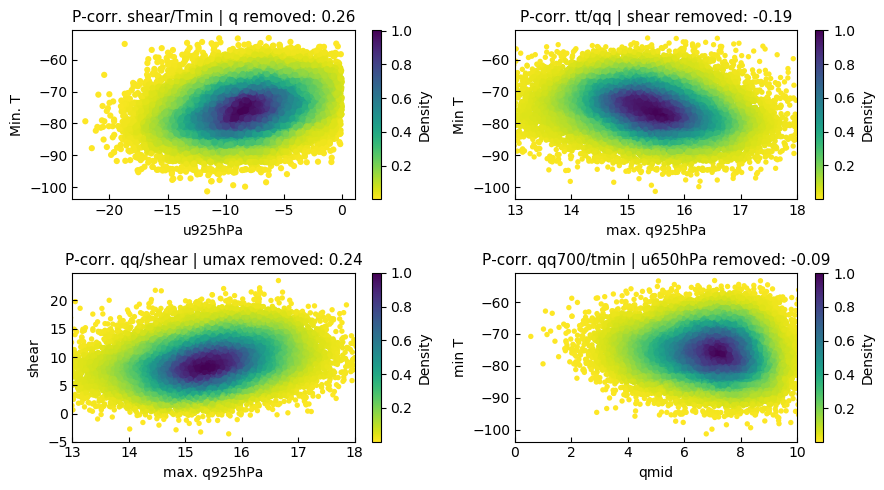

In [69]:
plot_scatter_month(ds_march)

In [39]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=np.percentile(cp4_march.shear,p1)) & (cp4_march.shear<=np.percentile(cp4_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
shear25_march = np.percentile(cp25_march.shear[(cp25_march.shear>=np.percentile(cp25_march.shear,p1)) & (cp25_march.shear<=np.percentile(cp25_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))




abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, p1) , np.percentile(ds_march.q925, p2), nbq) 
qbinsc_march = np.linspace(np.percentile(cp4_march.q925, p1) , np.percentile(cp4_march.q925, p2), nbq)
qbinsc25_march = np.linspace(15 , np.percentile(cp25_march.q925, p2), nbq)

nbqq = 5
nbss = 5

p1 = 10
p2 = 90

shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,1)) & (obsp.shear<=np.percentile(obsp.shear,99))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))
shear_cp4p = np.percentile(cp4p.shear[(cp4p.shear>=np.percentile(cp4p.shear,p1)) & (cp4p.shear<=np.percentile(cp4p.shear,p2))], np.linspace(0,100,nbss)) #np.percentile(cp4p.shear[(cp4p.shear>=8) & (cp4p.shear<=20)], np.linspace(0,100,nbss))
shear_cp25p = np.percentile(cp25p.shear[(cp25p.shear>=np.percentile(cp25p.shear,p1)) & (cp25p.shear<=np.percentile(cp25p.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25p.shear[(cp25p.shear>=8) & (cp25p.shear<=20)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, 1) , np.percentile(obsp.q925, 99), nbqq)
qbinsc= np.linspace(np.percentile(cp4p.q925, p1) , np.percentile(cp4p.q925, p2), nbqq)
qbinsc25 = np.linspace(15, np.percentile(cp25p.q925, p2), nbqq)


In [40]:
shear_cp25p

array([ 9.03373322, 12.14674466, 14.16167801, 16.23155976, 19.25791367])

In [41]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmin[poss_ds], 10)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 75)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 75)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [42]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<50] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [43]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [46]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [47]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [48]:
cp4perc_mar, cp4pr_mar, cp4area_mar, cp4val_mar = create_2dhist(cp4_march, shearc_march, qbinsc_march)

In [49]:
cp25perc_mar, pc25pr_mar, cp25area_mar, cp25val_mar = create_2dhist(cp25_march, shear25_march, qbinsc25_march)

In [50]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)
cp4perc, pc4, cp4area, cp4val = create_2dhist(cp4p, shear_cp4p, qbinsc)
cp25perc, pc25, cp25area, cp25val = create_2dhist(cp25p, shear_cp25p, qbinsc25)

In [51]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

9.018628486485207
15.340541798957464


In [53]:
ds_mar_dic = {
    'data' : dsperc_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
    'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [54]:
cp4_mar_dic = {
    'data' : cp4perc_mar,
    'ybins' : qbinsc_march,
    'xbins' : shearc_march,
    'title' : 'CP4',
    'valid' : cp4val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],1),
    'vmax' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [55]:
cp25_mar_dic = {
    'data' : cp25perc_mar,
    'ybins' : qbinsc25_march,
    'xbins' : shear25_march,
    'title' : 'P25',
    'valid' : cp25val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],1),
    'vmax' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [56]:
pcobs[pcobs==0]=np.nan
obsp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : '',
    'valid' : obsval,
    'cbarlabel' : '95th centile p',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc4[pc4==0]=np.nan
cp4_dic = {
    'data' : pc4,
    'ybins' : qbinsc,
    'xbins' : shear_cp4p,
    'title' : '',
    'valid' : cp4val,
    'cbarlabel' : '95th centile p',
    'vmin' : np.percentile(pc4[(pc4!=0) & np.isfinite(pc4)],1),
    'vmax' : np.percentile(pc4[(pc4!=0) & np.isfinite(pc4)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc25[pc25==0]=np.nan
cp25_dic = {
    'data' : pc25,
    'ybins' : qbinsc25,
    'xbins' : shear_cp25p,
    'title' : '',
    'valid' : cp25val,
    'cbarlabel' : '95th centile Max.p',
    'vmin' : np.percentile(pc25[(pc25!=0) & np.isfinite(pc25)],1),
    'vmax' : np.percentile(pc25[(pc25!=0) & np.isfinite(pc25)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

(array([1.000e+00, 2.000e+00, 1.400e+01, 3.600e+01, 1.330e+02, 2.930e+02,
        6.100e+02, 1.196e+03, 2.166e+03, 1.535e+03]),
 array([-65.99490949, -64.40726555, -62.8196216 , -61.23197766,
        -59.64433371, -58.05668977, -56.46904582, -54.88140187,
        -53.29375793, -51.70611398, -50.11847004]),
 <a list of 10 Patch objects>)

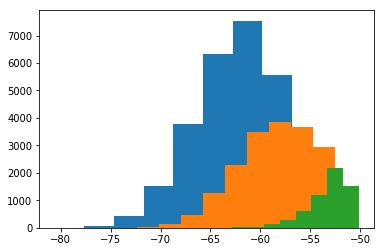

In [57]:
plt.hist(ds_march.tmean)
plt.hist(cp4_march.tmean)
plt.hist(cp25_march.tmean)

In [58]:
data_list = [ds_mar_dic, cp4_mar_dic, cp25_mar_dic,obsp_dic,cp4_dic,cp25_dic]

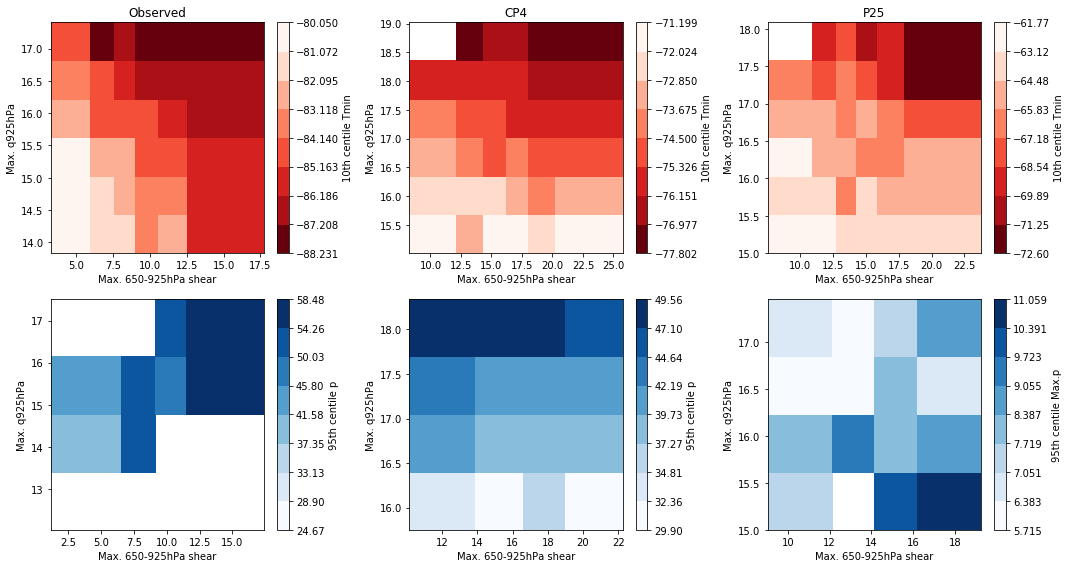

In [59]:
hist2d_six(data_list, valid=True)